# Title : Credit card fraud detection

It is important that credit card companies are able to recognize fraudulent credit card transactions so that customers are not charged for items that they did not purchase.

The dataset contains transactions made by credit cards in September 2013 by European cardholders.
This dataset presents transactions that occurred in two days, where we have 492 frauds out of 284,807 transactions. The dataset is highly unbalanced, the positive class (frauds) account for 0.172% of all transactions.

It contains only numerical input variables which are the result of a PCA transformation. Unfortunately, due to confidentiality issues, we cannot provide the original features and more background information about the data. Features V1, V2, … V28 are the principal components obtained with PCA, the only features which have not been transformed with PCA are 'Time' and 'Amount'. Feature 'Time' contains the seconds elapsed between each transaction and the first transaction in the dataset. The feature 'Amount' is the transaction Amount, this feature can be used for example-dependant cost-sensitive learning. Feature 'Class' is the response variable and it takes value 1 in case of fraud and 0 otherwise.

Given the class imbalance ratio, we recommend measuring the accuracy using the Area Under the Precision-Recall Curve (AUPRC). Confusion matrix accuracy is not meaningful for unbalanced classification.

**What problem do you solve?**

It's a problem on the kaggle site and it's a credit card fraud detection problem.

https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud

# Load Libraries

In [1]:
import numpy as np
import pandas as pd
import os, time
import pickle, gzip
import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()
import matplotlib as mpl
from sklearn import preprocessing as pp
from sklearn.model_selection import train_test_split 
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.metrics import roc_curve, auc, roc_auc_score

import warnings
warnings.filterwarnings('ignore')

# Load Data

In [2]:
data = pd.read_csv('input/creditcard.csv')
data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


# Preprocessing

**To create feature matrices and label arrays**

We're going to generate a feature matrix X, which is the data we're going to use for prediction, and we're going to separate the label matrix y(1 is fraud, 0 is normal).

In [3]:
# Split to train and test and scale features
dataX = data.drop(['Class'],axis=1)
dataY = data.loc[:,'Class'].copy()

X_train, X_test, y_train, y_test = \
    train_test_split(dataX, dataY, test_size=0.33, \
                    random_state=2018, stratify=dataY)
    
featuresToScale = X_train.columns
sX = pp.StandardScaler(copy=True)
X_train.loc[:,featuresToScale] = sX.fit_transform(X_train.loc[:,featuresToScale])
X_test.loc[:,featuresToScale] = sX.transform(X_test.loc[:,featuresToScale])

data_X = data.drop('Class', axis = 1)
data_y = data['Class']

**Data Scaling**

Scale the data so that the mean is 0 and the variance is 1 using StandardScaler, which is the scale adjustment scale of sklearn.

If you do not scale, the explanable variance may be distorted depending on the size of the variable during dimension reduction, so standardization must be carried out before dimension reduction.

In [4]:
featuresToScale = data_X.columns
sX = pp.StandardScaler(copy=True)
data_X.loc[:,featuresToScale] = sX.fit_transform(data_X[featuresToScale])

**Split into training and test datasets**

You need to create a training dataset to learn machine learning algorithms, and a test dataset to be predicted by machine learning algorithms. Performance on this test dataset will be the ultimate measure of success for machine learning projects.

We divided 67% of the original dataset into training datasets, 33% into test datasets, fixed random_state 2018 to facilitate results reproduction, and set stratification parameters, stratify to data_y to keep training and test datasets fraudulent (0.17%). Therefore, the training and test datasets retain the same percentage of fraudulent data.

In [5]:
X_train, X_test, y_train, y_test = train_test_split(data_X, data_y, test_size=0.33, random_state=2018, stratify=data_y)

**To create an outlier evaluation function and a visualization function**

In [6]:
def anomalyScores(originalDF, reducedDF):
    loss = np.sum((np.array(originalDF)-np.array(reducedDF))**2, axis = 1)
    loss = pd.Series(data=loss, index=originalDF.index)
    loss = (loss-np.min(loss))/(np.max(loss)-np.min(loss))
    return loss

def plotResults(trueLabels, anomalyScores, returnPreds = False):
    preds = pd.concat([trueLabels, anomalyScores], axis=1)
    preds.columns = ['trueLabel', 'anomalyScore']
    precision, recall, thresholds = precision_recall_curve(preds['trueLabel'],preds['anomalyScore'])
    average_precision = average_precision_score(preds['trueLabel'],preds['anomalyScore'])
    
    plt.step(recall, precision, color='k', alpha=0.7, where='post')
    plt.fill_between(recall, precision, step='post', alpha=0.3, color='k')

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    
    plt.title('Precision-Recall curve: Average Precision = {0:0.2f}'.format(average_precision))

    fpr, tpr, thresholds = roc_curve(preds['trueLabel'], preds['anomalyScore'])
    areaUnderROC = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, color='r', lw=2, label='ROC curve')
    plt.plot([0, 1], [0, 1], color='k', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    
    plt.title('Receiver operating characteristic: Area under the curve = {0:0.2f}'.format(areaUnderROC))
    plt.legend(loc="lower right")
    plt.show()
    
    if returnPreds==True:
        return preds
        
def scatterPlot(xDF, yDF, algoName):
    tempDF = pd.DataFrame(data=xDF.loc[:,0:1], index=xDF.index)
    tempDF = pd.concat((tempDF,yDF), axis=1, join="inner")
    tempDF.columns = ["First Vector", "Second Vector", "Label"]
    sns.lmplot(x="First Vector", y="Second Vector", hue="Label", data=tempDF, fit_reg=False)
    ax = plt.gca()
    ax.set_title("Separation of Observations using "+algoName)

# EDA

**Check the Train Feature distribution**

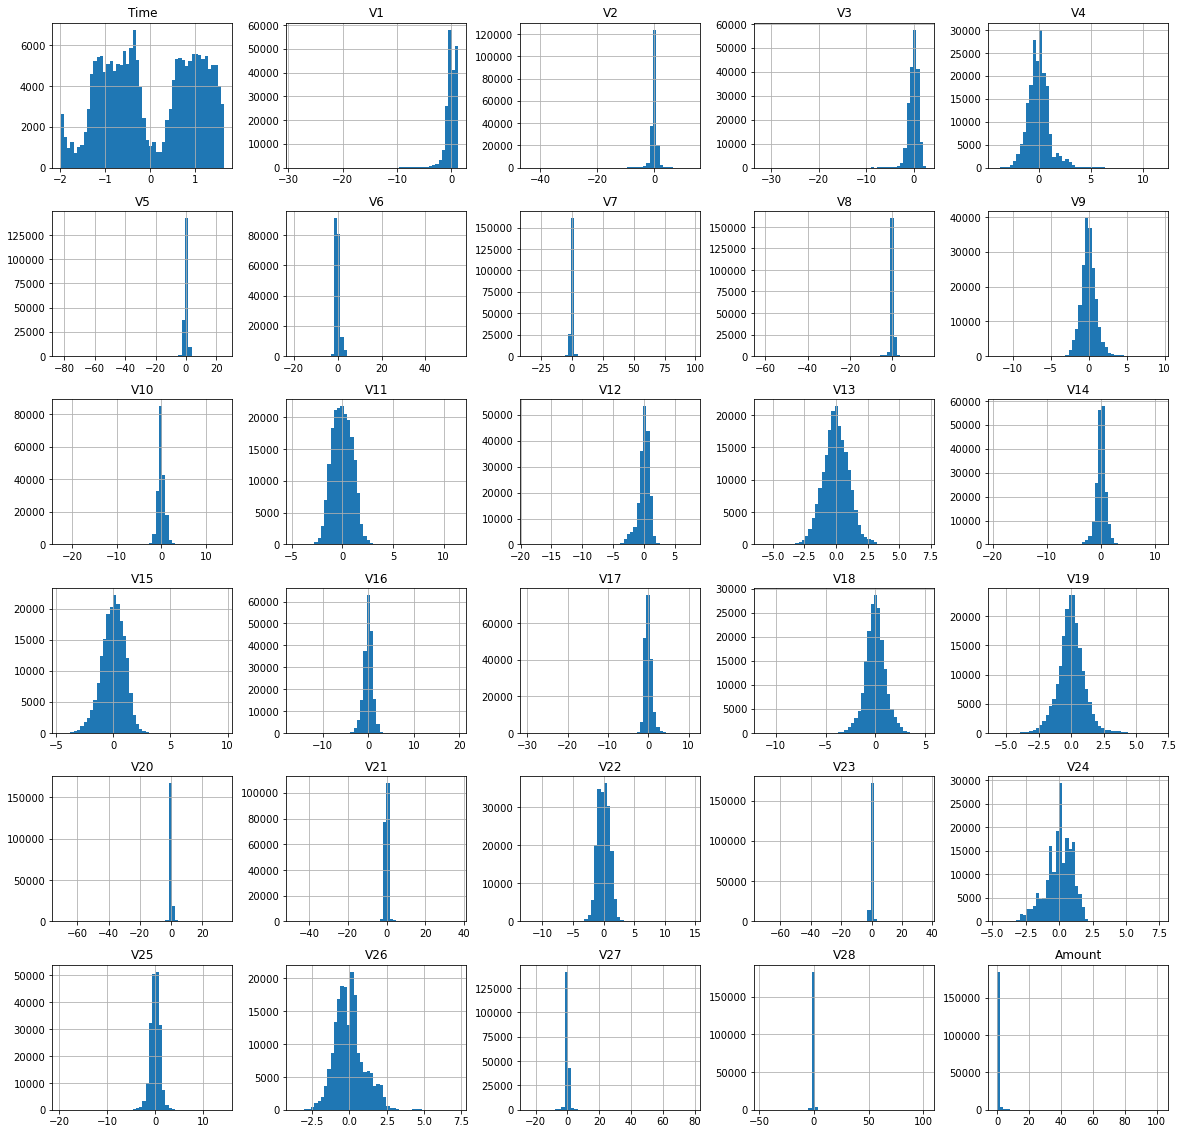

In [7]:
X_train.hist(bins = 50, figsize = (20,20))
plt.show()

# PCA

**What ML approach do you use, or what methods does your app use?**

Create and evaluate 4 unsupervised learning models as listed below.

1. SRP
2. Nonlinear
3. pre-learning
4. ICA

**1.Strong value detection using SRP**

Random Projection, such as SRP, preserves the distance between vectors and allows you to change dimensions into lower dimensions.

SRP is one of the random projection techniques, which, if the original data is a KxN matrix, transforms N-dimensional into M-dimensions by multiplying it by a random NxM matrix, and is named random projection.

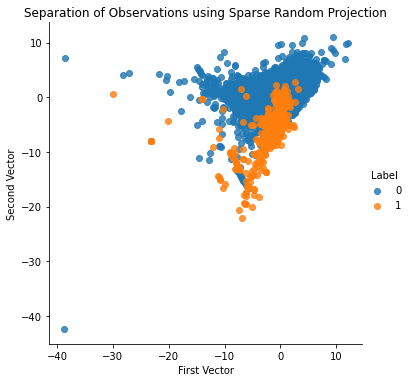

In [8]:
from sklearn.random_projection import SparseRandomProjection

n_components = 27
density = 'auto'
eps = .01
dense_output = True
random_state = 123

SRP = SparseRandomProjection(n_components=n_components, 
                             density=density, 
                             eps=eps, 
                             dense_output=dense_output,
                             random_state=random_state)

X_train_SRP = SRP.fit_transform(X_train)
X_train_SRP = pd.DataFrame(data=X_train_SRP, index=X_train.index)

scatterPlot(X_train_SRP, y_train, "Sparse Random Projection")

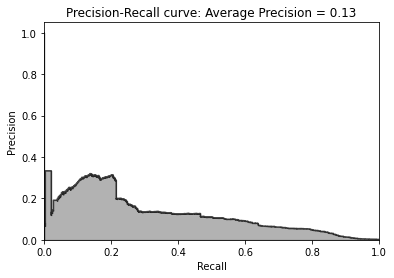

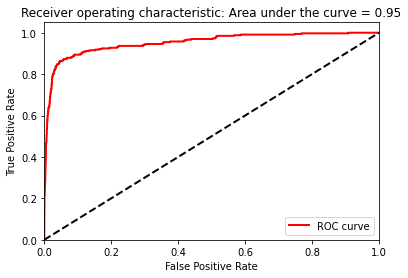

In [9]:
X_train_SRP_inverse = np.array(X_train_SRP).dot(SRP.components_.todense())
X_train_SRP_inverse = pd.DataFrame(data=X_train_SRP_inverse, index=X_train.index)

anomalyScoresSRP = anomalyScores(X_train, X_train_SRP_inverse)
plotResults(y_train, anomalyScoresSRP)

You can see that the results are not very good to use as an anomaly detection system.

**2.Non-linear Outliers Detected**

The techniques we learned last time, such as Isomap, MDS, lle, and tsne, are implemented as sklearn.manifold internal functions.

We skipped this part in the book, but here we're going to train with only 2,000 samples, as we did in the kernel PCA.

**ISOMAP**

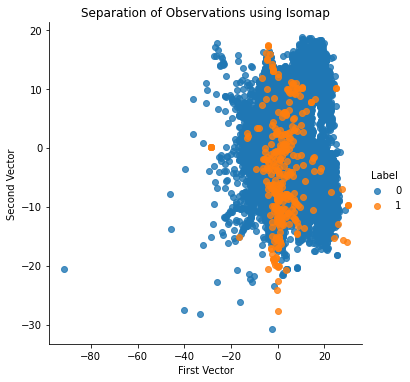

In [10]:
from sklearn.manifold import Isomap

n_components = 27

ISOMAP = Isomap(n_components=n_components)

X_train_ISOMAP = ISOMAP.fit(X_train.iloc[:2000])
X_train_ISOMAP = X_train_ISOMAP.transform(X_train)
X_train_ISOMAP = pd.DataFrame(data=X_train_ISOMAP, index=X_train.index)

scatterPlot(X_train_ISOMAP, y_train, "Isomap")

**LLE**

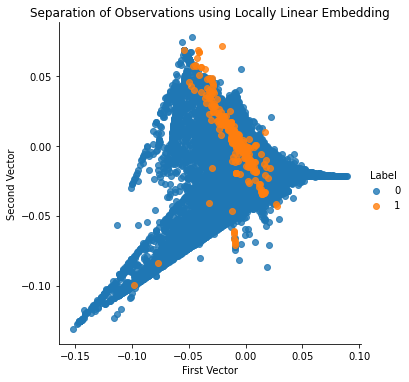

In [11]:
from sklearn.manifold import LocallyLinearEmbedding

n_components = 27
random_state = 123

LLE = LocallyLinearEmbedding(n_components=n_components, random_state=random_state)

X_train_LLE = LLE.fit(X_train.iloc[:2000])
X_train_LLE = X_train_LLE.transform(X_train)
X_train_LLE = pd.DataFrame(data=X_train_LLE, index=X_train.index)

scatterPlot(X_train_LLE, y_train, "Locally Linear Embedding")

It is not suitable for fraud detection solutions because it runs very slowly, has poor performance, and uses a lot of memory.

**3.Strange detection using pre-learning**

The pre-learning model can specify a batch size.

**What is batch size?**

It refers to dividing a subset of the current data samples. For example, if you specify batch_size 100 when you have 700 data, we can divide it into seven batches and proceed with the learning.

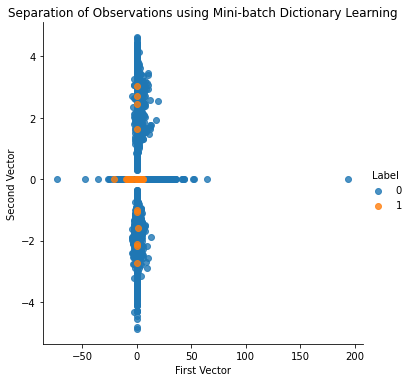

In [12]:
# Mini-batch dictionary learning
from sklearn.decomposition import MiniBatchDictionaryLearning

n_components = 28
alpha = 1
batch_size = 200
n_iter = 10
random_state = 123

miniBatchDictLearning = MiniBatchDictionaryLearning( \
    n_components=n_components, alpha=alpha, batch_size=batch_size, \
    n_iter=n_iter, random_state=random_state)

miniBatchDictLearning.fit(X_train)
X_train_miniBatchDictLearning = \
    miniBatchDictLearning.fit_transform(X_train)
X_train_miniBatchDictLearning = \
    pd.DataFrame(data=X_train_miniBatchDictLearning, index=X_train.index)

scatterPlot(X_train_miniBatchDictLearning, y_train, \
            "Mini-batch Dictionary Learning")

Visualization shows that the pre-learning model does not detect anomalies well.

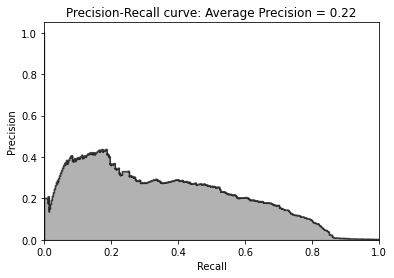

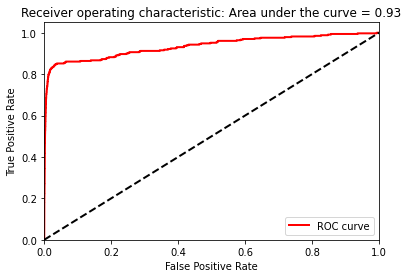

In [13]:
# View plot
X_train_miniBatchDictLearning_inverse = \
    np.array(X_train_miniBatchDictLearning). \
    dot(miniBatchDictLearning.components_)

X_train_miniBatchDictLearning_inverse = \
    pd.DataFrame(data=X_train_miniBatchDictLearning_inverse, \
                 index=X_train.index)

anomalyScoresMiniBatchDictLearning = anomalyScores(X_train, \
    X_train_miniBatchDictLearning_inverse)
preds = plotResults(y_train, anomalyScoresMiniBatchDictLearning, True)

Looking at the above precision-recall graph, it is a model that does not perform well for anomaly detection.

**4.Strange detection using ICA**

ICA is an independent component analysis (ICA), a calculation method that separates multivariate signals into statistically independent subcomponents.

ICA is a nonlinear anomaly detection technique and is the same as a normal PCA (because it finds the base vector representing the given data)

Differences between regular PCA and ICA:

- PCA: Priority - Quartz Variance Maximum Vector

- ICA: Priority - Results are as independent as possible

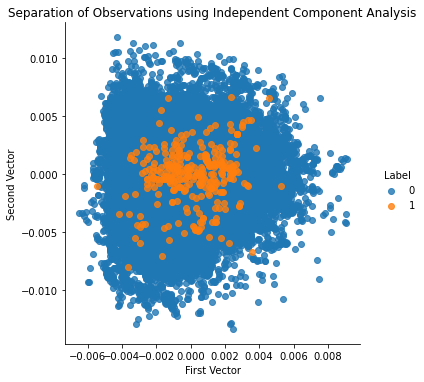

In [14]:
from sklearn.decomposition import FastICA

n_components = 27
algorithm = 'parallel'
whiten = True
max_iter = 200
random_state = 123

fastICA = FastICA(n_components=n_components, \
    algorithm=algorithm, whiten=whiten, max_iter=max_iter, \
    random_state=random_state)

X_train_fastICA = fastICA.fit_transform(X_train)
X_train_fastICA = pd.DataFrame(data=X_train_fastICA, index=X_train.index)

X_train_fastICA_inverse = fastICA.inverse_transform(X_train_fastICA)
X_train_fastICA_inverse = pd.DataFrame(data=X_train_fastICA_inverse, \
                                       index=X_train.index)

scatterPlot(X_train_fastICA, y_train, "Independent Component Analysis")

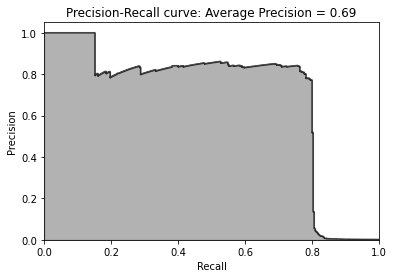

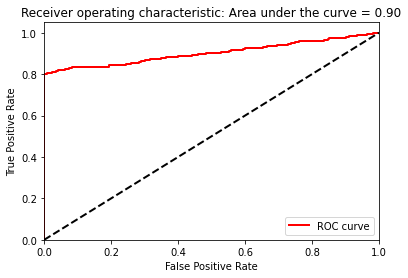

In [15]:
anomalyScoresFastICA = anomalyScores(X_train, X_train_fastICA_inverse)
preds = plotResults(y_train, anomalyScoresFastICA, True)

In [16]:
preds.sort_values(by="anomalyScore",ascending=False,inplace=True)
cutoff = 350
predsTop = preds[:cutoff]
print("Precision: ",np.round(predsTop. \
            anomalyScore[predsTop.trueLabel==1].count()/cutoff,2))
print("Recall: ",np.round(predsTop. \
            anomalyScore[predsTop.trueLabel==1].count()/y_train.sum(),2))
print("Fraud Caught out of 330 Cases:", predsTop.trueLabel.sum())

Precision:  0.75
Recall:  0.8
Fraud Caught out of 330 Cases: 264


The creation of an outlier detection model using ICA shows that, like the PCA model, the average precision is 0.75 and 80% detection of fraudulent transactions is possible.

# Result

**Show the result or run an app demo.**

The best performance is as follows.

Precision:  0.75

Recall:  0.8

Fraud Caught out of 330 Cases: 264

# Conclusion

Using unsupervised machine learning-based anomaly detection techniques, we created a fraudulent transaction detection model and compared the results.

Among the outliers detection techniques we tried this time, the best performance was using the ICA technique using 27 main components.